In [1]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from latent_immunity_relative_fitness import RelativeFitnessDR, LatentRW, LatentSplineRW

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [3]:
#raw_seq = pd.read_csv("../../evofr/test/testing_data/mlr-variant-counts.tsv", sep="\t")
#raw_seq = raw_seq[raw_seq.location == "City0"]
#data = ef.VariantFrequencies(raw_seq, pivot="C")

In [4]:
#raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/variants-us/variants-us_location-variant-sequence-counts.tsv", sep="\t")
#raw_seq
#data = ef.VariantFrequencies(raw_seq)
#data = ef.HierFrequencies(raw_seq, group="location")

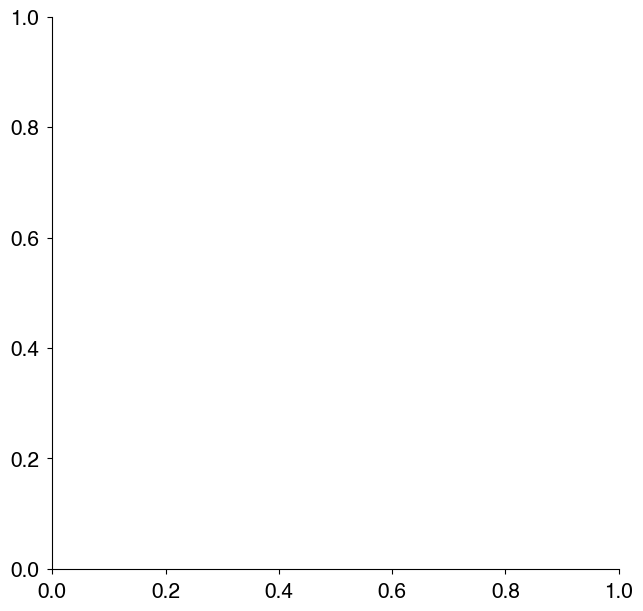

In [9]:
from scipy import stats


def add_latent_distance(row):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p


In [7]:
clade_definitions = [
    {
        "clade": "24B",
        "display_name": "24B (JN.1.11.1)",
        "defining_lineage": "JN.1.11.1",
        "color": '#DC2F24'
    },
    {
        "clade": "24A",
        "display_name": "24A (JN.1)",
        "defining_lineage": "JN.1",
        "color": '#E4632E'
    },
    {
        "clade": "23I",
        "display_name": "23I (BA.2.86)",
        "defining_lineage": "BA.2.86",
        "color": '#E69136'
    },
    {
        "clade": "23H",
        "display_name": "23H (HK.3)",
        "defining_lineage": "HK.3",
        "color": '#D9AD3D'
    },
    {
        "clade": "23G",
        "display_name": "23G (XBB.1.5.70)",
        "defining_lineage": "XBB.1.5.70",
        "color": '#C1BA47'
    },
    {
        "clade": "23F",
        "display_name": "23F (EG.5.1)",
        "defining_lineage": "EG.5.1",
        "color": '#A2BE57'
    },
    {
        "clade": "23E",
        "display_name": "23E (XBB.2.3)",
        "defining_lineage": "XBB.2.3",
        "color": '#83BA70'
    },
    {
        "clade": "23D",
        "display_name": "23D (XBB.1.9)",
        "defining_lineage": "XBB.1.9",
        "color": '#69B091'
    },
    {
        "clade": "23C",
        "display_name": "23C (CH.1.1)",
        "defining_lineage": "CH.1.1",
        "color": '#549DB2'
    },
    {
        "clade": "23B",
        "display_name": "23B (XBB.1.16)",
        "defining_lineage": "XBB.1.16",
        "color": '#4580CA'
    },
    {
        "clade": "23A",
        "display_name": "23A (XBB.1.5)",
        "defining_lineage": "XBB.1.5",
        "color": '#462EB9'
    },
    {
        "clade": "22F",
        "display_name": "22F (XBB)",
        "defining_lineage": "XBB",
        "color": '#3E58CF'
    },
    {
        "clade": "22E",
        "display_name": "22E (BQ.1)",
        "defining_lineage": "BQ.1",
        "color": '#777777'
    },
    {
        "clade": "22D",
        "display_name": "22D (BA.2.75)",
        "defining_lineage": "BA.2.75",
        "color": '#777777'
    },
    {
        "clade": "22B",
        "display_name": "22B (BA.5)",
        "defining_lineage": "BA.5",
        "color": '#777777'
    },
    {
        "clade": "other",
        "display_name": "other",
        "defining_lineage": False,
        "color": '#777777'
    }
]

In [10]:
from pango_aliasor.aliasor import Aliasor
import colorsys

def order_lineages(lineages, aliasor):
    """
    Order input lineages by using their full uncompressed lineage & converting to a sortable form
    e.g. BA.5  -> B.1.1.529.5  -> '  B/001/001/529/005'
         BA.16 -> B.1.1.529.16 -> '  B/001/001/529/016'
         so BA.5 is before BA.16
    """
    def _lineage_sortable(lineage):
        if lineage=='other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i==0 else f"{int(x):03}") for i,x in enumerate(lin_full.split('.'))])
    return sorted(lineages,key=_lineage_sortable)

def order_lineages_within_clade(lineages, aliasor, clade_map):
    """
    Order input lineages by their clades first and then by using their full uncompressed lineage,
    converting to a sortable form within each clade.

    Parameters:
    lineages (list of str): List of lineage names to be sorted.
    aliasor (object): An object with a method `uncompress` that converts compressed lineage names to full lineage names.
    clades (list of str): List of clade assignments corresponding to each lineage.

    Returns:
    list of str: Sorted list of lineage names.

    Example:
    >>> class Aliasor:
    ...     def uncompress(self, lineage):
    ...         return {"BA.5": "B.1.1.529.5", "BA.16": "B.1.1.529.16", "BA.2": "B.1.1.529.2"}[lineage]
    >>> aliasor = Aliasor()
    >>> lineages = ["BA.5", "BA.16", "BA.2"]
    >>> clades = ["Clade1", "Clade1", "Clade2"]
    >>> order_lineages(lineages, aliasor, clades)
    ['BA.5', 'BA.16', 'BA.2']
    """

    def _lineage_sortable(lineage):
        if lineage == 'other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i == 0 else f"{int(x):03}") for i, x in enumerate(lin_full.split('.'))])
    
    # Sort the lineages first by clade and then by the sortable form of the lineage
    return sorted(lineages, key=lambda lineage: (clade_map[lineage], _lineage_sortable(lineage)))

def lineage_to_clade(lineage, aliasor, fallback, clade_definitions):
    lineage_full = aliasor.uncompress(lineage)
    for clade_data in clade_definitions:
        if clade_data['clade']=='other':
            continue
        comparison_lineage = aliasor.uncompress(clade_data['defining_lineage'])
        if lineage_full == comparison_lineage or lineage_full.startswith(comparison_lineage + "."):
            return clade_data['clade']
    return fallback

def clade_colors(variants, clade_definitions):
    colors = {c['clade']: c['color'] for c in clade_definitions}
    missing = set()
    defs = []
    for v in variants:
        try:
            defs.append([v, colors[v]])
        except KeyError:
            if v!='other':
                missing.add(v)
                defs.append([v, DEFAULT_CLADE_COLOR])

    # TODO: Emit this to output file so it can be sent thru Slack notifications
    if len(missing) > 0:
        print(
            f"Missing definitions for the following clades: {', '.join(missing)}.",
            f"They have been assigned the default color {DEFAULT_CLADE_COLOR!r}"
        )

    return defs

def clade_display_names(variants, clade_definitions):
    display_names = {c['clade']: c['display_name'] for c in clade_definitions}
    return [[name, display_names[name] if name in display_names else name]
            for name in variants]

def colour_range(anchor, n):
    """
    Create a range of `n` colours centred around the provided `anchor`.
    This currently involves simple manipulations in HLS space, but
    the outputs aren't going to be as good as they could be if we did it in
    a perceptually uniform space (e.g lab space). For the purposes of this viz
    I don't think it's a dealbreaker, and in our current setup it's hard to use
    python libraries which aren't already available in our various runtimes.
    """
    anchor_rgb = tuple(int(anchor.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    anchor_hls = colorsys.rgb_to_hls(*anchor_rgb)
    hrange = np.linspace(anchor_hls[0]*0.85, anchor_hls[0]*1.25, n)
    lrange = np.linspace(anchor_hls[1]*1.2, anchor_hls[1], n)
    srange = np.linspace(anchor_hls[2]*0.7, anchor_hls[2]*1.1, n)
    rgb_range = [colorsys.hls_to_rgb(*hls) for hls in zip(hrange, lrange, srange)]
    def clamp(x):
        return int(max(0, min(x, 255)))
    return [f"#{clamp(rgb[0]):02x}{clamp(rgb[1]):02x}{clamp(rgb[2]):02x}" for rgb in rgb_range]

def colourise(lineages, aliasor, clade_definitions):
    """
    Produces an array of arrays associating observed lineages with a colour hex. Example output:
        [
            ['XBB', '#ffffff'],
            ...
        ]
    """
    clades = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in lineages}

    colours = []

    for clade in list(set(clades.values())):
        matching_lineages = [l for l in lineages if clades[l]==clade] # will be ordered
        print(f"{clade:<10}n={len(matching_lineages)} lineages")
        color_hex = [x['color'] for x in clade_definitions if x['clade']==clade][0]
        for pair in zip(matching_lineages, colour_range(color_hex, len(matching_lineages))):
            colours.append(pair)
    return colours

aliasor = Aliasor()
#color_map = colourise(posterior.data.var_names, aliasor, clade_definitions)
#color_map = {entry[0]: entry[1] for entry in color_map}
#clade_map = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
#              for lineage in posterior.data.var_names}

In [11]:
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

def get_ordering(var_names):
    
    #reordered_names = order_lineages(var_names, aliasor)[:-1]
    reordered_names = order_lineages_within_clade(var_names, aliasor, clade_map)[:-1]
    reordered_clades = [clade_map[n] for n in reordered_names]

    reordered_idx = [var_names.index(r) for r in reordered_names]
    return reordered_idx, reordered_names, reordered_clades
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

# Merge in latent distnances
def add_latent_distance(row, var_to_index):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan

def add_bracket(ax, start, end, label, y_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    y_offset : float, optional
        The vertical offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(start, y_offset), xytext=(end, y_offset),
                arrowprops=dict(arrowstyle='<|-|>', lw=3.0, **kwargs))
    ax.text((start + end) * 0.5, y_offset - height, label,
            ha='center', va='center', **kwargs)
    
def add_clade_dividers(ax, reordered_clades, height=-0.4, y_offset=4.5):
    current_clade = reordered_clades[0]
    start = 0

    for i in range(1, len(reordered_clades)):
        if reordered_clades[i] != current_clade:
            add_bracket(ax, start-0.5, i-0.5, current_clade, y_offset=y_offset, height=height)
            current_clade = reordered_clades[i]
            start = i
            
    # Add bracket for the last group
    add_bracket(ax, start - 0.5, len(reordered_clades)-1 + 0.5, current_clade, y_offset=y_offset, height=height)

In [14]:
    
def _plot_mds_location(ax, dim_1, dim_2):
    ax.scatter(phi_transformed[:,dim_1], phi_transformed[:,dim_2], 
                   ec="k", 
                   color="white",
                   s=480)
    ax.set_xlabel(f"Pseudo immunity dim {dim_1+1}")
    ax.set_ylabel(f"Pseudo immunity dim {dim_2+1}")   
                
    # Add names to locations
    for i, txt in enumerate(posterior.data.names):
        ax.annotate(txt, (phi_transformed[i,dim_1], phi_transformed[i,dim_2]), rotation=0, size=14, weight="bold", ha='center', va="center_baseline")
    return None
    

In [16]:
antigenic_map = pd.concat([pd.read_csv("../data/antigenic_map_data/immunized human.csv"), 
                           pd.read_csv("../data/antigenic_map_data/naive human.csv")])
antigenic_map_melt = antigenic_map.melt(["id", "group"], var_name="strain", value_name="NT50")

In [17]:
def compute_log2_distances(X):
    X_transformed = np.log2(X.values)
    return np.sqrt(np.sum(np.square(X_transformed.T[..., None] - X_transformed), axis=1))

def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

X = antigenic_map.drop(columns=["id", "group"])
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)

In [18]:
def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

distances_dfs = []
for name, group in antigenic_map.groupby("group"):
    X = group.drop(columns=["id", "group"])
    distances = compute_log2_distances(X)
    _distance_df = create_titer_distance_df(X)
    _distance_df["group"] = name
    distances_dfs.append(_distance_df)

distances_dfs = pd.concat(distances_dfs)

In [23]:
distances_dfs

,variant_1,variant_2,titer_distance,group
0,D614G,D614G,0.000000,BA.5 BTI
1,Beta,D614G,2.660460,BA.5 BTI
2,Beta,Beta,0.000000,BA.5 BTI
3,BA.1,D614G,11.123402,BA.5 BTI
4,BA.1,Beta,11.188021,BA.5 BTI
...,...,...,...,...
205,KP.3,BA.2.86,0.201634,XBB infection
206,KP.3,JN.1,0.000000,XBB infection
207,KP.3,BA.2.87.1,0.722466,XBB infection
208,KP.3,JN.1.23,0.000000,XBB infection


In [81]:
antigenic_map_melt

,id,group,strain,NT50,log2_titer
0,JN.1-36,BA.5/BF.7 BTI + JN.1 infection,D614G,1381,10.431498
1,JN.1-49,BA.5/BF.7 BTI + JN.1 infection,D614G,463,8.854868
2,JN.1-2,BA.5/BF.7 BTI + JN.1 infection,D614G,4862,12.247334
3,JN.1-5,BA.5/BF.7 BTI + JN.1 infection,D614G,310,8.276124
4,JN.1-52,BA.5/BF.7 BTI + JN.1 infection,D614G,577,9.172428
...,...,...,...,...,...
1355,VAC26,WT vaccine,KP.3,20,4.321928
1356,BA.5.2-61nv,BA.5 infection,KP.3,20,4.321928
1357,BA.5.2-60nv,BA.5 infection,KP.3,20,4.321928
1358,BA.5.2-43nv,BA.5 infection,KP.3,20,4.321928


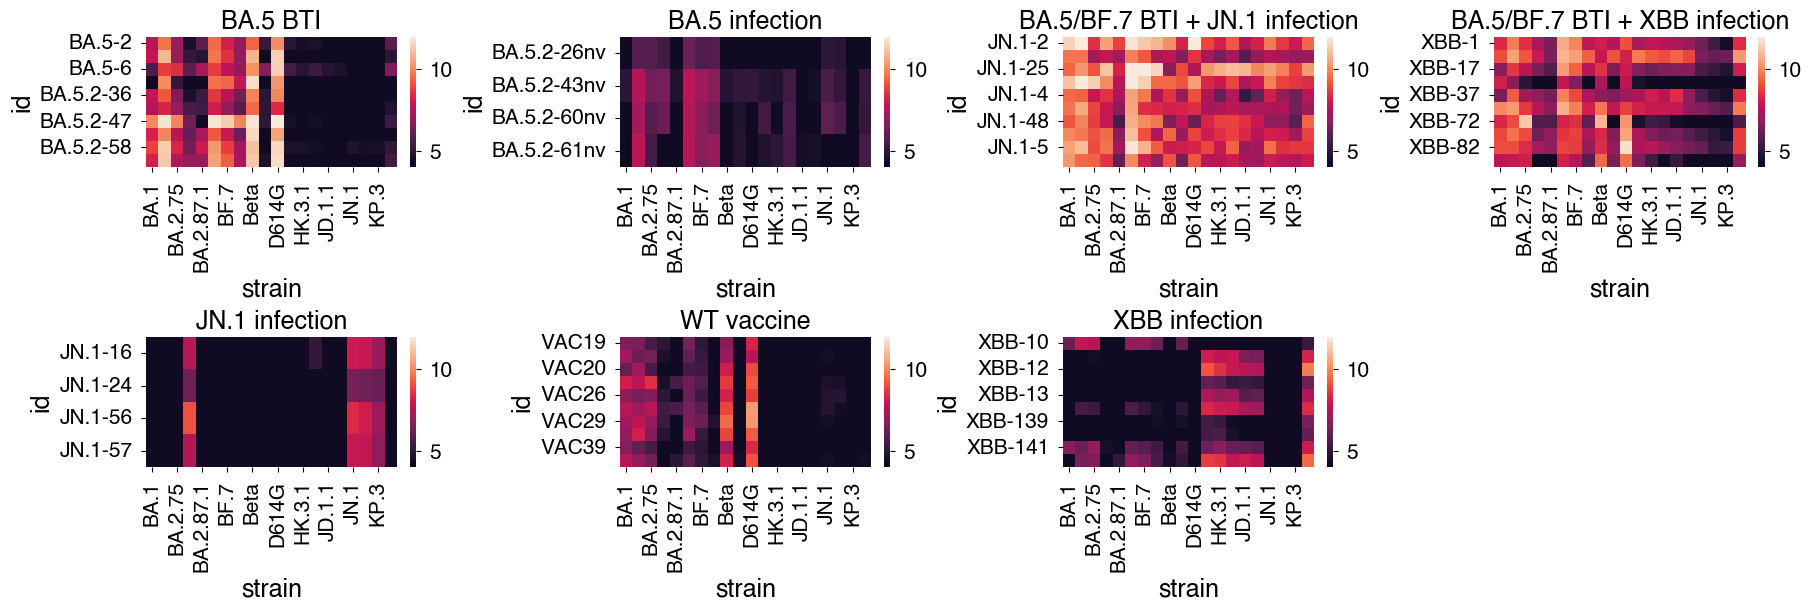

In [88]:

import seaborn as sns


fig = plt.figure(figsize=(18., 6), constrained_layout=True)
n_groups = antigenic_map_melt["group"].nunique()
spec = fig.add_gridspec(2, 4)


antigenic_map_melt["log2_titer"] = np.log2(antigenic_map_melt["NT50"])

for i, (name, group) in enumerate(antigenic_map_melt.groupby("group")):
    
    ax = fig.add_subplot(spec[i])
    d = group.drop_duplicates().pivot(index="id", columns="strain", values="log2_titer")
    plot = sns.heatmap(d, ax=ax, vmin=4, vmax=12)
    plot.set_title(name)

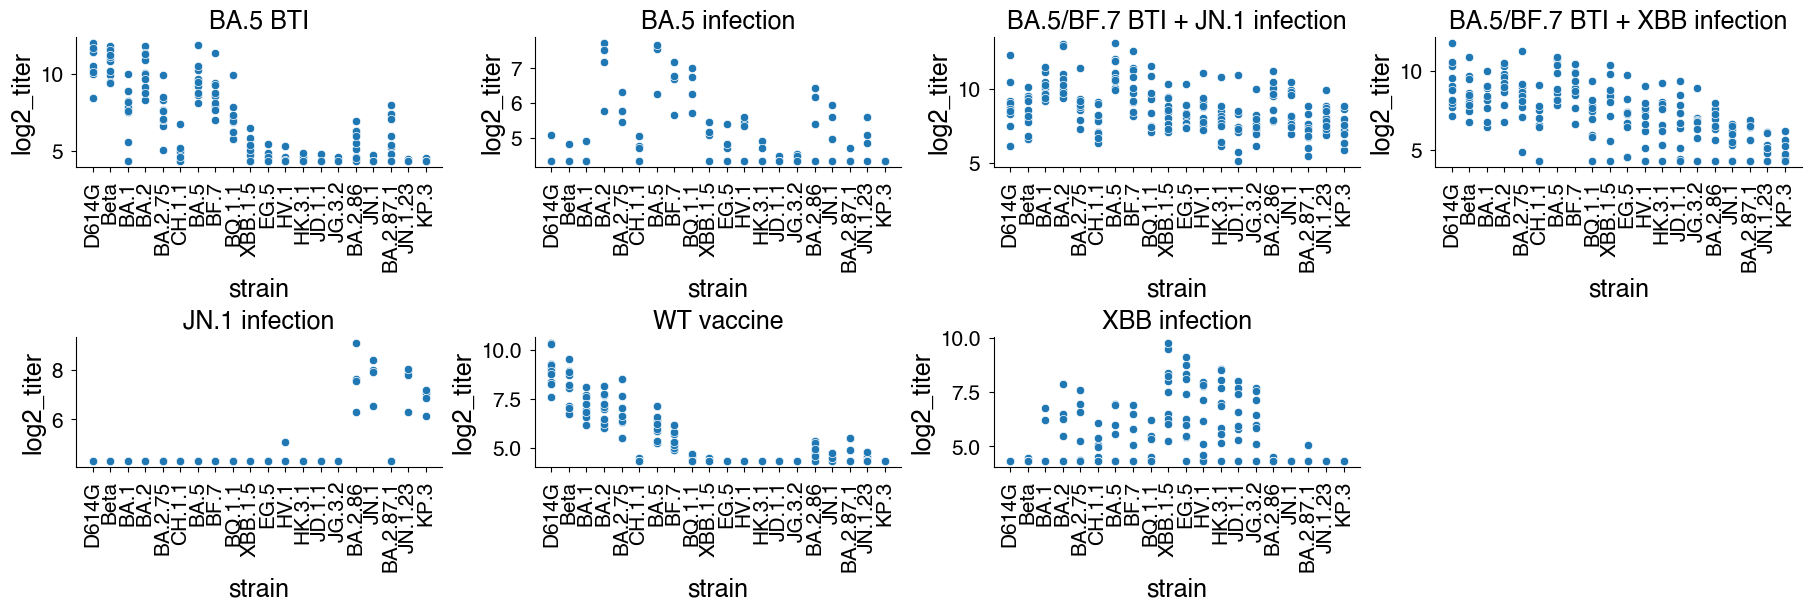

In [92]:

import seaborn as sns


fig = plt.figure(figsize=(18., 6), constrained_layout=True)
n_groups = antigenic_map_melt["group"].nunique()
spec = fig.add_gridspec(2, 4)


antigenic_map_melt["log2_titer"] = np.log2(antigenic_map_melt["NT50"])

for i, (name, group) in enumerate(antigenic_map_melt.groupby("group")):
    
    ax = fig.add_subplot(spec[i], sharey=ax if i > 0 else None)
    plot = sns.scatterplot(x="strain", y="log2_titer", data=group, ax=ax)
    plot.set_title(name)
    plot.tick_params(axis='x', rotation=90)

In [113]:
antigenic_map_melt["log2_titer"] = np.log2(antigenic_map_melt["NT50"])
X = antigenic_map_melt[["id", "strain", "log2_titer"]]
X = X.drop_duplicates().pivot(index="id", columns="strain", values="log2_titer")
pca = PCA(X.values)

strain,BA.1,BA.2,BA.2.75,BA.2.86,BA.2.87.1,BA.5,BF.7,BQ.1.1,Beta,CH.1.1,D614G,EG.5,HK.3.1,HV.1,JD.1.1,JG.3.2,JN.1,JN.1.23,KP.3,XBB.1.5
id,,,,,,,,,,,,,,,,,,,,
BA.5-2,7.584963,9.640245,7.087463,4.523562,5.930737,9.503826,8.139551,6.930737,9.405141,5.169925,10.117643,4.857981,4.459432,4.584963,4.321928,4.321928,4.321928,4.321928,4.321928,5.857981
BA.5-3,7.832890,10.909893,7.000000,5.087463,4.807355,9.656425,8.562242,6.870365,10.859535,4.321928,11.436712,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.906891
BA.5-6,5.584963,8.761551,8.483816,5.930737,7.383704,8.744834,7.672425,6.930737,10.179909,6.727920,11.421539,5.426265,4.857981,5.285402,4.807355,4.584963,4.321928,4.321928,4.321928,6.475733
BA.5.2-26nv,4.321928,5.754888,5.754888,5.392317,4.321928,6.247928,5.643856,5.700440,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.954196,4.857981,4.321928,4.321928
BA.5.2-28,4.321928,10.076816,5.044394,4.321928,4.321928,9.623881,9.428360,7.851749,11.690871,4.321928,10.306062,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928
BA.5.2-36,7.781360,9.179909,6.584963,4.584963,5.247928,8.643856,7.629357,6.247928,9.939579,4.906891,9.978710,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928
BA.5.2-39,7.499846,8.280771,7.011227,5.491853,5.357552,8.103288,7.022368,5.781360,9.479780,4.954196,8.400879,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.321928,4.700440
BA.5.2-43nv,4.906891,7.523562,6.321928,6.426265,4.700440,7.658211,7.169925,6.754888,4.807355,5.044394,5.087463,4.807355,4.700440,5.321928,4.321928,4.459432,5.584963,5.087463,4.321928,5.169925
BA.5.2-47,10.015415,11.793197,9.942515,6.266787,4.321928,11.858370,11.364135,9.929258,11.825754,5.000000,12.044394,4.523562,4.321928,4.459432,4.321928,4.321928,4.321928,4.321928,4.321928,5.247928


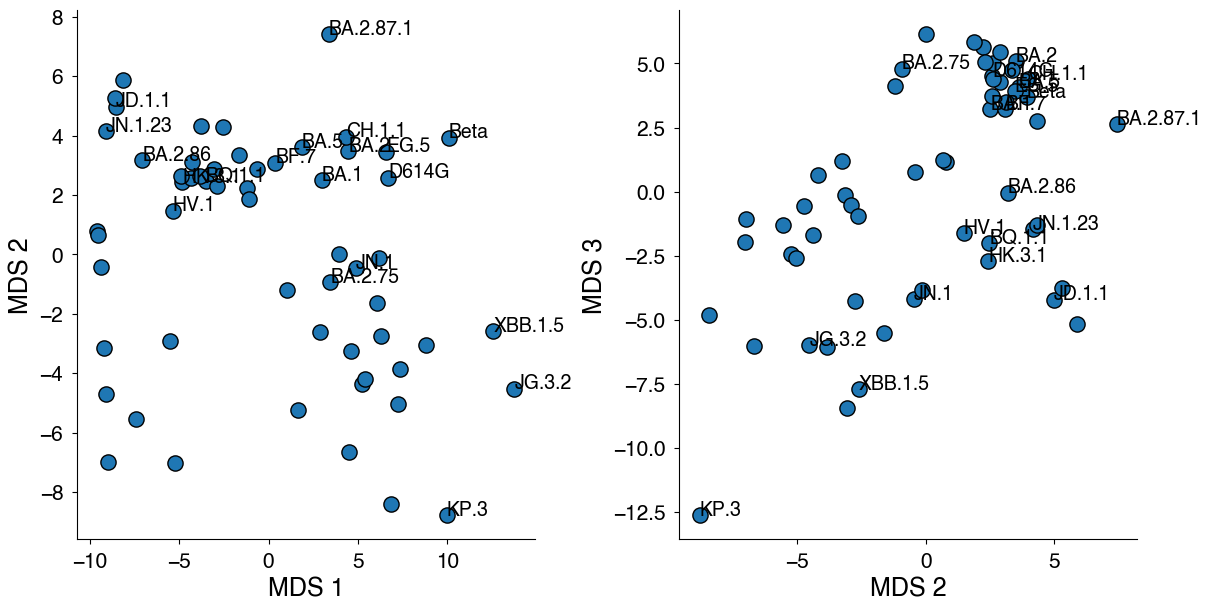

In [114]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

def plot_mds_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"MDS {dim1+1}")
        ax.set_ylabel(f"MDS {dim2+1}")
        # Annotate
        for i, txt in enumerate(X.columns):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None

mds = MDS(n_components=3, normalized_stress="auto", random_state=12)
X_transformed = mds.fit_transform(X)

ax = fig.add_subplot(spec[0])
plot_mds_dims(ax, X_transformed, 0, 1 )
ax = fig.add_subplot(spec[1])
plot_mds_dims(ax, X_transformed, 1, 2)

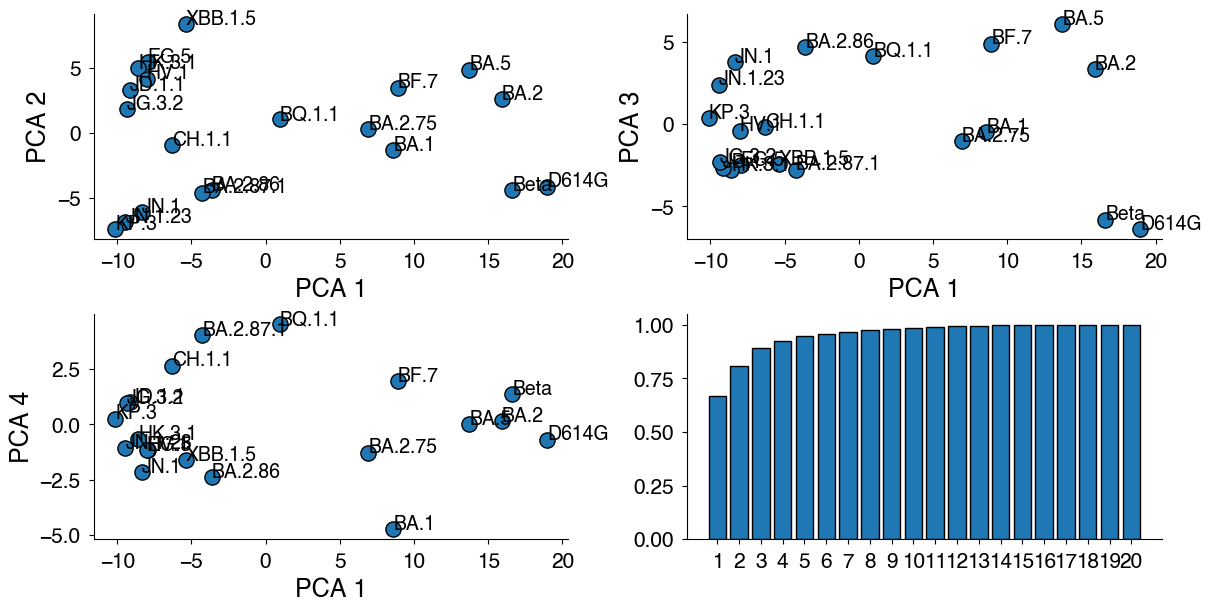

In [176]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)

def plot_pca_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"PCA {dim1+1}")
        ax.set_ylabel(f"PCA {dim2+1}")
        # Annotate
        for i, txt in enumerate(X.columns):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None

pca = PCA()
X_transformed = pca.fit_transform(X.T)

ax = fig.add_subplot(spec[0])
plot_pca_dims(ax, X_transformed, 0, 1 )
ax = fig.add_subplot(spec[1])
plot_pca_dims(ax, X_transformed, 0, 2)
ax = fig.add_subplot(spec[2])
plot_pca_dims(ax, X_transformed, 0, 3)


ax = fig.add_subplot(spec[1, 1])
ax.bar(np.arange(pca.n_components_) + 1, np.cumsum(pca.explained_variance_ratio_), ec="k")
ax.set_xticks(np.arange(pca.n_components_) + 1)

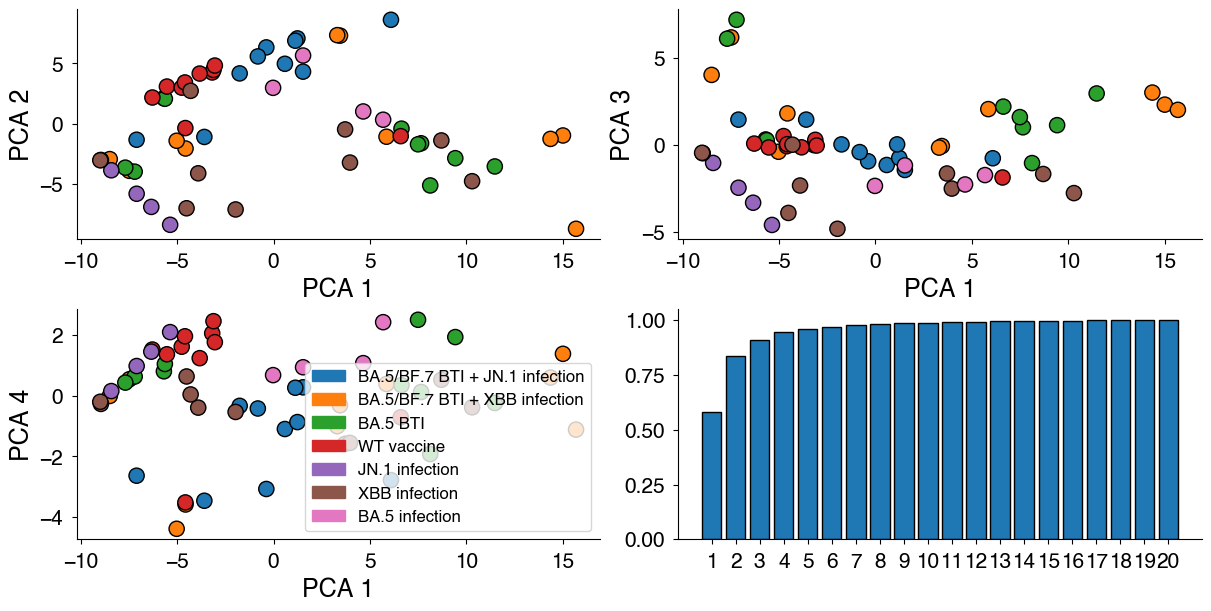

In [204]:
import matplotlib.pyplot as plt
import itertools
from matplotlib.patches import Patch

# Generate a simple color palette (this can be any list of colors)
colors = plt.get_cmap('tab10').colors  # Using a colormap with 10 distinct colors

# Create an iterator that cycles through the colors
color_cycle = itertools.cycle(colors)

# Create a dictionary that will map strings to colors
string_color_map = {}

def get_color_for_string(s):
    # If the string is not already in the map, assign it a new color
    if s not in string_color_map:
        string_color_map[s] = next(color_cycle)
    return string_color_map[s]

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)

def plot_pca_dims(ax, X, X_transformed, dim1, dim2, legend=False, annotate=False):
        id_group = antigenic_map_melt[["id", "group"]].drop_duplicates()
        c = [get_color_for_string(s) for s in id_group["group"]]
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120, c=c)
        ax.set_xlabel(f"PCA {dim1+1}")
        ax.set_ylabel(f"PCA {dim2+1}")
        
        if legend:
            # Create custom legend handles
            labels = id_group["group"].unique()
            legend_patches = [Patch(color=string_color_map[label], label=label) for label in labels]

            # Add a custom legend to the plot
            ax.legend(legend_patches, labels)

        # Annotate
        if annotate:
            for i, txt in enumerate(X.columns):
                ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None

pca = PCA()
X_transformed = pca.fit_transform(X)

ax = fig.add_subplot(spec[0])
plot_pca_dims(ax, X.T, X_transformed, 0, 1 )
ax = fig.add_subplot(spec[1])
plot_pca_dims(ax, X.T, X_transformed, 0, 2)
ax = fig.add_subplot(spec[2])
plot_pca_dims(ax, X.T, X_transformed, 0, 3, legend=True)


ax = fig.add_subplot(spec[1, 1])
ax.bar(np.arange(pca.n_components_) + 1, np.cumsum(pca.explained_variance_ratio_), ec="k")
ax.set_xticks(np.arange(pca.n_components_) + 1)

In [132]:
# color pca by each of the groups

20

In [ ]:
# Could we meaningfully predict for all strains?

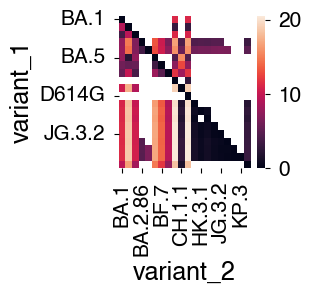

In [41]:
import seaborn as sns


fig = plt.figure(figsize=(3., 12.), constrained_layout=True)
n_groups = distances_dfs["group"].nunique()
spec = fig.add_gridspec(n_groups, 1)


for i, (name, group) in enumerate(distances_dfs.groupby("group")):
    
    ax = fig.add_subplot(spec[i])
    d = group.pivot(index="variant_1", columns="variant_2", values="titer_distance")
    plot = sns.heatmap(d, ax=ax)
    break

In [ ]:
# We could show that the completed matrix mirrors the distances we see?

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_27996/904527701.py:59: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


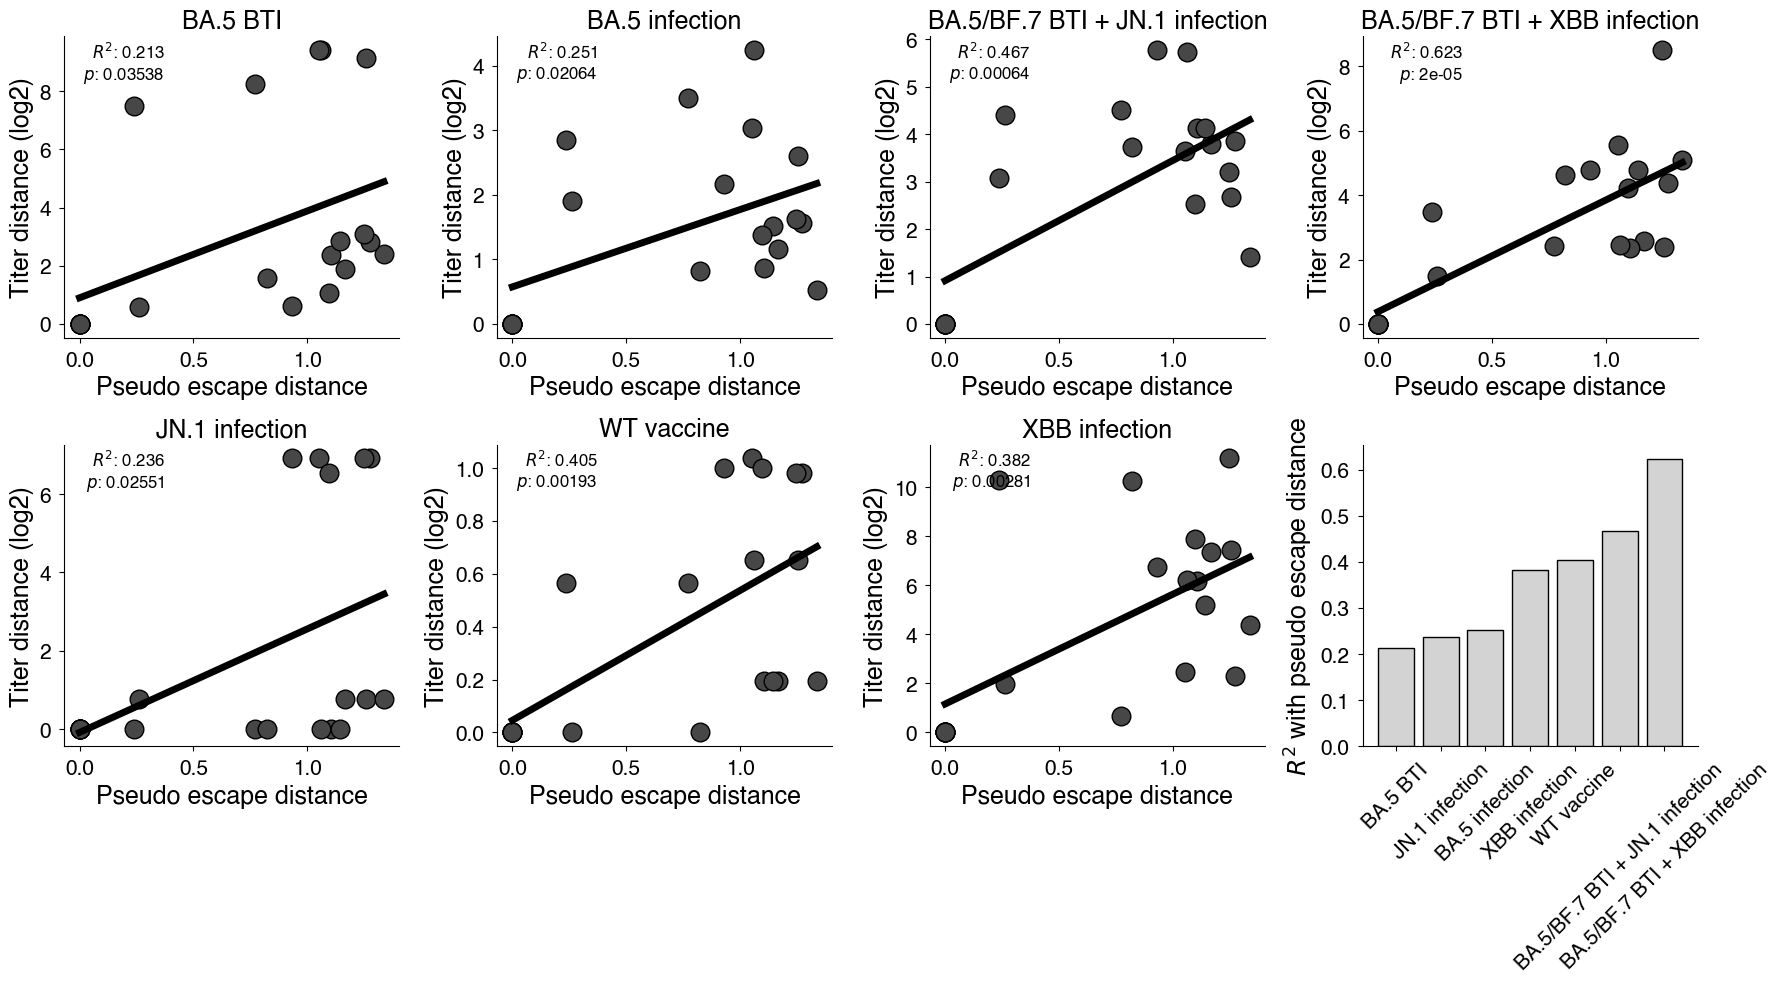

In [99]:
fig = plt.figure(figsize=(18., 10.), constrained_layout=True)
spec = fig.add_gridspec(2,4)

## Prepping data and labels
eta = posterior.samples["eta"][0, :-1, :] # Remove other
n_vars, n_comps = eta.shape

eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
var_names = posterior.data.var_names
var_to_index = {v: i for i, v in enumerate(var_names)}        

def add_latent_distance(row):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
distances_dfs["latent_distance"] = distances_dfs.apply(add_latent_distance, axis=1)
    
# Fit linear regression
def fit_linear(df, col1, col2):
    x, y = df[col1], df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

correlation_df = []
for i, (name, group) in enumerate(distances_dfs.groupby("group")):
    ax = fig.add_subplot(spec[i])
    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = group[x_col], group[y_col]
    ax.scatter(x, y, ec="k", color="#474747", s=180)            

    # Fit linear regression between two variables
    xs, ys, r, p = fit_linear(group, x_col, y_col)
    ax.plot(xs, ys, color="k")

    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))
    ax.text(0.3, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes)
    ax.set_xlabel("Pseudo escape distance")
    ax.set_ylabel("Titer distance (log2)")
    ax.set_title(name)
    
    correlation_df.append({"group": name, "R2": r ** 2})
    
correlation_df = pd.DataFrame(correlation_df).sort_values(by="R2")

ax = fig.add_subplot(spec[-1])
ax.bar(correlation_df.group, correlation_df.R2, ec="k", color="lightgrey")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel(r"$R^2$ with pseudo escape distance")
fig.tight_layout()

fig.savefig("../manuscript/supplementary_figures/titer_pseudo_escape_distance_by_group.png")

In [ ]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(1,2)
ax = fig.add_subplot(spec[0])
